# Lab Assignment 1: Exploring Text Data
## by Aviraj Sinha (Avi)

### 1. Business Understanding

All html files are collected from the IMDb archive in the domain of movies. Each of the 30,000 documents is a review. The reviews are professionally written and are posted to different online newsgroups. Data collected by Bo Pang and Lillian Lee. http://www.cs.cornell.edu/people/pabo/movie-review-data/


#### Purpose of the Data and Analysis
Understanding human sentiment is an important part of businesses to understand the consumers relationship management (CRM). Since humans are verbal communicators, simple numbers are not an accurate indicator. Numeric rating systems can only describe sentiment to a certain extent and are not always available. A better approach is to understand general sentiment from the vocabulary collected in freely available reviews and posts. 

This knowledge of sentiment can be especially beneficial when applied to movie distributers who want a deeper understanding of what qualities make a movie successful before they spend millions to market, manufacture and distribute them through channels (either streamed or physical). This way more financially viable movies can be chosen from studios and sold based on reviews. In the end, distributers make money from lucrative movies and consumers would get what they wanted to watch.

#### Prediction Task
The nuances can become extremely fine-grained with implict meanings such as intent, emotion, subjectivity. However, this prediction task would be a basic polarity analysis, a simple positive or negative, coupled with key words describing them, which is basically enough to take decent advantage of the wealth of data available. 

#### Level of Accuracy
The success of this task would result in basic classification of a review as positive or negative by analyzing vocabulary used. The level of success of this kind of classification depends on the length of the review and the complexity of the language used to describe it. Taking all this together, the required accuracy for this data classification to be of use would be around 90+ percent or above because any false classification could result in the movie not being distributed or wrongly distributed in place of a better performer, thus causing massive losses in revenue through wasted production.



In [5]:
import glob
import re
import string
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import words
from yellowbrick.text import FreqDistVisualizer
from stemmer import *
import stemmer as mystem
#suffixes from www.thoughco.com
#sentiment vocabulary from:
#http://ptrckprry.com/course/ssd/data/negative-words.txt
#http://ptrckprry.com/course/ssd/data/positive-words.txt

### 2. Data Encoding

#### 2.1 Read in raw text documents

In [3]:

#read in document raw and preprocess
#removing punctutation and return characters as as well as html no_tags
#using fast c level code such as translate and regex to improve speed
#read in as byte code to drastically improve speed
#over 30000 reviews documents in html text format
def preprocess(text):
    text= re.sub(b"<.*?>", b" ", text)#no_tags
    text= re.sub(b"\n", b" ", text)#no_new_lines
    text= re.sub(b"\r", b" ", text)#no_returns
    #lowered with no punctuation
    text= text.translate(None, b'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~').lower()
    #removing the footer for all the reviews
    text= text[:-579]
    return text

char_count=[]#keep track of characters
documents = []
for filename in glob.glob('polarity_html/sample/*.html'):
    with open(filename, 'rb') as f:
        raw = f.read()
        char_count.append(len(raw))
        cleaned = preprocess(raw)
        documents.append(cleaned)


print(len(documents))

#code to see raw vesion
example_raw = open("polarity_html/movie/0020.html")
example_raw.read()

print(example_raw)
#code to view cleaned version
print(documents[0])


2836
<_io.TextIOWrapper name='polarity_html/movie/0020.html' mode='r' encoding='UTF-8'>
b'     review for 84 charlie mopic 1989              84 charlie mopic 1989   reviewed by  hettingerkryptonarcnasagov                                        84 mopic charlie                         a film review by larry hettinger                          copyright 1989 larry hettinger         if you are looking for a movie that offers something different than the  usual cinema treatment of the war in vietnam you are going to be disappointed  with 84 mopic charlie  first of all the movie should be called 84 mumble  charlie  throughout most of the first half of the movie the dialogue is  indecipherable and in the second half it is only somewhat more understandable  because the characters spend most of their time yelling         this movie contributes nothing to our understanding of this war  there is  absolutely no topic dealt with that was not better treated in films such as  platoon apocalypse now o

#### 2.2 Implement Stemming, convert data from raw text into sparse encoded bag-of-words

In [3]:
#using english stop words and my stemmer
analyzer = CountVectorizer(decode_error='ignore').build_analyzer()

def stemmed_words(doc):
    return (mystem.stem(w) for w in analyzer(doc))
#218,754 without change
#169,256 with professional stemmer
#198,484 with my suffix/prefix remover
count_vect = CountVectorizer(stop_words= 'english', decode_error='ignore', analyzer=stemmed_words) # an object capable of counting words in a document!
bag_words = count_vect.fit_transform(documents)
print(bag_words.shape)
#find words with most count, see possible stop words that have not been coverted
df = pd.DataFrame(data=bag_words.toarray(), columns= count_vect.get_feature_names())

df.sum().sort_values()[-10:]

(2836, 55073)


for      17181
film     19057
it       19435
that     21570
is       38469
to       48902
         50351
d        53008
of       54804
the     125153
dtype: int64

#### 2.3 Verify Data Quality, Convert the data into a sparse encoded tf-idf representation.

In [6]:
domain_specific_stop_words = ["movie", "review","reviewed", "copyright", "film", "story", "plot", "director", "characters", "character", "film", "scene", "scenes"]
stop_words = text.ENGLISH_STOP_WORDS.union(domain_specific_stop_words)

#min df ignore term that only occur in 1 percent of documents, max df ifnore therms that occur in more than half of the documents
#removed about 1/4 of the words
tfidf_vect = TfidfVectorizer(stop_words= stop_words, decode_error='ignore', min_df=0.01, max_df=0.70)
tfidf_bag_words = tfidf_vect.fit_transform(documents)
tf_df = pd.DataFrame(data=tfidf_bag_words.toarray(),columns=tfidf_vect.get_feature_names())

#top 10 for each
tf_df.sum().sort_values()[-10:]

time            58.423873
1993            58.869855
berardinelli    59.423536
just            63.733174
james           67.824584
films           69.805737
leeper          71.923970
mark            74.232739
good            74.369847
like            76.408684
dtype: float64

#### 2.4 Using Bigrams

In [5]:
#bigram count
bigram_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2))
#limit set to take a sample because bigram take a while
num_limit = int(len(documents)/100)
bigram_bag_words = bigram_count_vect.fit_transform(documents[:num_limit])
print(bigram_bag_words.shape) # this is a sparse matrix
bigram_count_vect.inverse_transform(bigram_bag_words[0])
bi_count_df = pd.DataFrame(data=bigram_bag_words.toarray(),columns=bigram_count_vect.get_feature_names())


# bigram tdidf
bi_tfidf_vect = TfidfVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2), min_df=0.01, max_df=0.70)
#limit set to take a sample because bigram take a while
num_limit = int(len(documents)/100)
bi_tfidf_bag_words = bi_tfidf_vect.fit_transform(documents[:num_limit])
bi_td_df = pd.DataFrame(data=bi_tfidf_bag_words.toarray(), columns=bi_tfidf_vect.get_feature_names())

print(bi_count_df.sum().sort_values()[-10:])
print(bi_td_df.sum().sort_values()[-10:])

(28, 9540)
science fiction        9
tale winter            9
fatal instinct        10
age innocence         12
jeff meyer            12
luck club             12
princess caraboo      14
joy luck              15
james berardinelli    20
basic instinct        20
dtype: int64
lola montes            0.405335
age innocence          0.437384
fatal instinct         0.450816
platter 1993           0.488074
combination platter    0.488074
joy luck               0.490502
basic instinct         0.535905
jeff meyer             0.545377
princess caraboo       0.560547
james berardinelli     0.577440
dtype: float64


#### 2.5 Using sentiment vocabulary

##### 2.5.1 Positive and Negative Vocab

In [7]:
#using postive sentiment vocabulary
positive_vocab_file = open("positive_sentiment_indicators.txt","r")
positive_voc = positive_vocab_file.read().split('\n')

pos_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', vocabulary=positive_voc)
pos_bag_words = pos_count_vect.fit_transform(documents)
pos_bag_words.shape
pos_df = pd.DataFrame(data=pos_bag_words.toarray(), columns=positive_voc)

#using negative sentiment vocabulary
negative_vocab_file = open("negative_sentiment_indicators.txt","r")
negative_voc = negative_vocab_file.read().split('\n')

neg_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', vocabulary=negative_voc)
neg_bag_words = neg_count_vect.fit_transform(documents)
neg_bag_words.shape
neg_df = pd.DataFrame(data=neg_bag_words.toarray(), columns=negative_voc)

print("Negatives:")
print(neg_df.sum().sort_values()[-10:])
print("Postives:")
print(pos_df.sum().sort_values()[-10:])

Negatives:
evil              450
wrong             451
unfortunately     503
problems          507
problem           626
death             637
hard              715
dead              725
funny             967
bad              1378
dtype: int64
Postives:
worth           752
interesting     992
right          1006
work           1340
better         1484
love           1526
great          1678
best           1954
good           4021
like           4616
dtype: int64


##### 2.5.2 Bigram adverb + sentiment vocab

In [7]:
#bigram with adverb and sentiment vocabulary
adverb_file = open("adverbs.txt","r")
adverbs_voc = adverb_file.read().split('\n')
#cartesian product to add adverbs in front of each sentiment word
adv_neg = list(map( lambda x: x[0]+ " " + x[1], itertools.product(adverbs_voc, negative_voc) ))
adv_pos = list(map( lambda x: x[0]+ " " + x[1], itertools.product(adverbs_voc, positive_voc) ))
adv_with_adj = adv_pos + adv_neg
adv_with_adj = list(set(adv_with_adj))

adv_bi_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2), vocabulary=adv_with_adj)
num_limit = int(len(documents)/10)
adv_bi_bag_words = adv_bi_count_vect.fit_transform(documents[:num_limit])
adv_bi_df = pd.DataFrame(data=adv_bi_bag_words.toarray(),columns=adv_bi_count_vect.get_feature_names())

adv_bi_df.sum().sort_values()[-10:]

just right           4
probably best        4
far better           4
right wrong          5
quite good           6
just like            6
lot fun              6
highly recommend     7
lot like             8
pretty good         11
dtype: int64

##### 2.5.3 Creating a new Dataframe

In [8]:
#Statistical dataframes by document. columns are pos, neg, vocab size, character number, sentiment vocab numbner and class score
data_stats = pd.DataFrame()
length = neg_bag_words.shape[0]
data_stats['positive_word_count'] = [ pos_count_vect.inverse_transform(pos_bag_words[doc])[0].size for doc in range(length)]
data_stats['negative_word_count'] = [ neg_count_vect.inverse_transform(neg_bag_words[doc])[0].size for doc in range(length)]
#total characters used
data_stats['total_char_count'] = char_count
#positive - negative sentiment words
data_stats["sentiment_score"] = data_stats.apply(lambda row: row.positive_word_count - row.negative_word_count, axis=1)
#how many sentiment vocabs occur
data_stats["sentiment_occurences"] = data_stats.apply(lambda row: row.positive_word_count + row.negative_word_count, axis=1)

def sentiment_level(row):

    if row.sentiment_occurences == 0:
        return "-1 No Sentiment"

    score = row.sentiment_score/row.sentiment_occurences

    if score > 0.333:
        #the good is double the bad
        return "6 Very Good"
    elif score > 0.2:
        #the good is 50% more the bad
        return "5 Good"
    elif score > 0.111:
        #the good is 25% more the bad
        return "4 Alright"
    elif score < -0.333:
        #the bad is double the good
        return "3 Very Bad"
    elif score < -0.2:
        #the bad is 50% more the good
        return "2 Bad"
    elif score < -0.111:
        #the bad is 25% more the good
        return "1 Not Alright"
    else:
        return "0 Neutral"

#0 or 1
data_stats["sentiment_class"] = data_stats.apply(lambda row: 1 if row.sentiment_score>0 else 0, axis=1)
#0-6 rating
data_stats["sentiment_level"] = data_stats.apply(lambda row: sentiment_level(row), axis=1)
data_stats.head()




,positive_word_count,negative_word_count,total_char_count,sentiment_score,sentiment_occurences,sentiment_class,sentiment_level
0,7,6,2957,1,13,1,0 Neutral
1,10,7,3866,3,17,1,4 Alright
2,57,50,13947,7,107,1,0 Neutral
3,30,24,5891,6,54,1,4 Alright
4,11,8,3663,3,19,1,4 Alright


In [9]:
data_stats.describe()
data_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 7 columns):
positive_word_count     2836 non-null int64
negative_word_count     2836 non-null int64
total_char_count        2836 non-null int64
sentiment_score         2836 non-null int64
sentiment_occurences    2836 non-null int64
sentiment_class         2836 non-null int64
sentiment_level         2836 non-null object
dtypes: int64(6), object(1)
memory usage: 155.2+ KB


### 3. Data Visualization: Visualize statistical summaries of the text data

#### 3.1 Statistical summaries

##### 3.1.1 Distributions

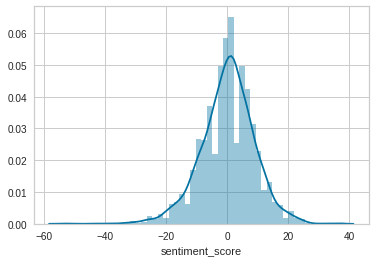

In [13]:
#histograms
warnings.filterwarnings('ignore')
sns.distplot(data_stats.sentiment_score);

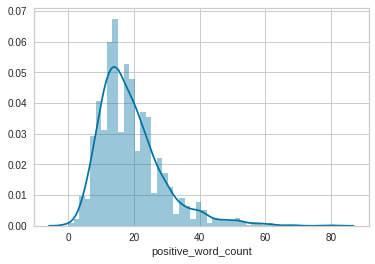

In [14]:
sns.distplot(data_stats.positive_word_count);

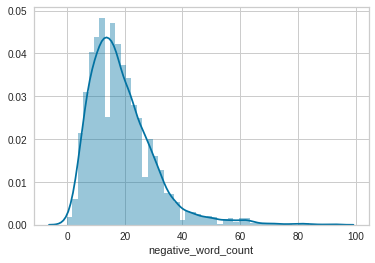

In [15]:
sns.distplot(data_stats.negative_word_count);

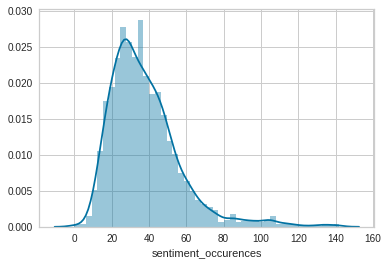

In [16]:
sns.distplot(data_stats.sentiment_occurences);

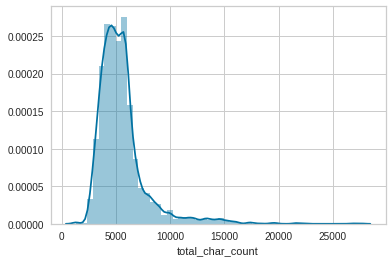

In [17]:
sns.distplot(data_stats.total_char_count);

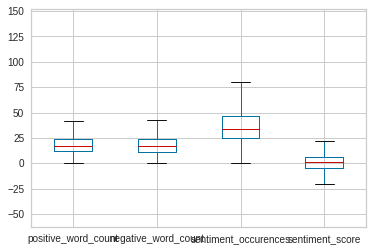

In [20]:
data_stats.boxplot(column=['positive_word_count', 'negative_word_count', 'sentiment_occurences')

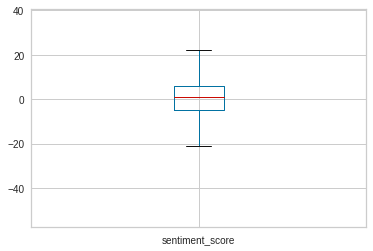

In [22]:
data_stats.boxplot(column=['sentiment_score'])

##### 3.1.2 Correlations

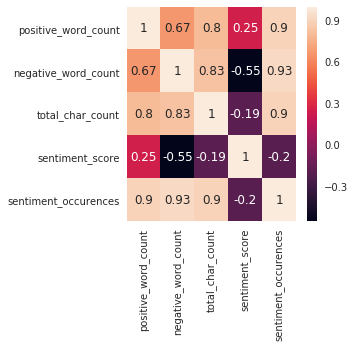

In [21]:
#heatmap
#interesting note that the sentiment score is more related to the negative occurences than positive. Character count related to negativity
drop = data_stats.drop(columns= ["sentiment_class"])
cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(drop.corr(), cmap=cmap, annot=True)
f.tight_layout()

#### 3.2  Target classes

##### 3.2.1 Bar Chart by Level of Sentiment

There were 4 reviews sentimental words rated -1 No Sentiment
There were 995 reviews sentimental words rated 0 Neutral
There were 368 reviews sentimental words rated 1 Not Alright
There were 289 reviews sentimental words rated 2 Bad
There were 180 reviews sentimental words rated 3 Very Bad
There were 380 reviews sentimental words rated 4 Alright
There were 300 reviews sentimental words rated 5 Good
There were 320 reviews sentimental words rated 6 Very Good


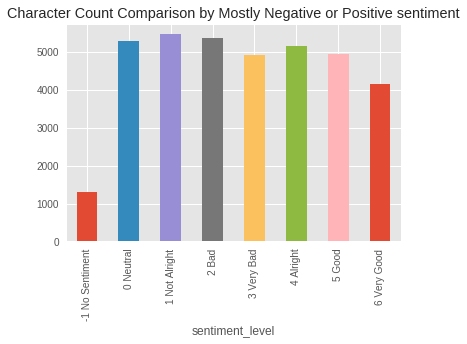

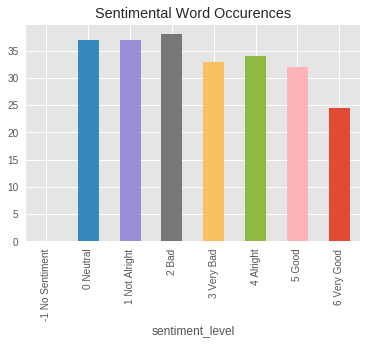

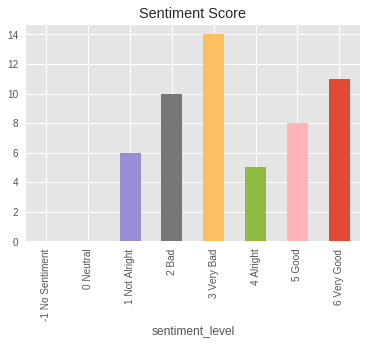

In [15]:
df_grouped_sentiments = data_stats.groupby(by='sentiment_level')
for val,grp in df_grouped_sentiments:
    print('There were',len(grp),'reviews sentimental words rated', val)

df_grouped_sentiments.describe()


#grouped bar charts for both
plt.style.use('ggplot')

character_count = df_grouped_sentiments.total_char_count.median()
ax = character_count.plot(kind='bar')
plt.title('Character Count Comparison by Mostly Negative or Positive sentiment')
plt.show()

sentiment_occurences = df_grouped_sentiments.sentiment_occurences.median()
ax = sentiment_occurences.plot(kind='bar')
plt.title('Sentimental Word Occurences')
plt.show()

sentiment_score = abs(df_grouped_sentiments.sentiment_score.median())
ax = sentiment_score.plot(kind='bar')
plt.title('Sentiment Score')
plt.show()

###### 3.2.2 Term Frequencies

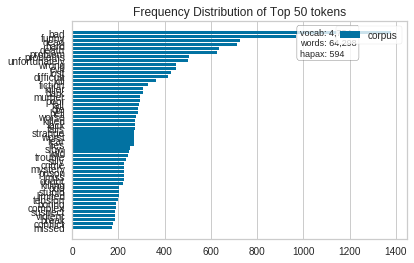

In [11]:
#term frquency charts
neg_features = neg_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=neg_features)
visualizer.fit(neg_bag_words)
visualizer.poof()

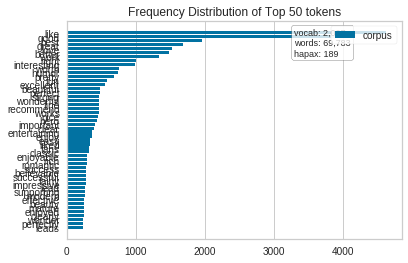

In [12]:
pos_features = pos_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=pos_features)
visualizer.fit(pos_bag_words)
visualizer.poof()

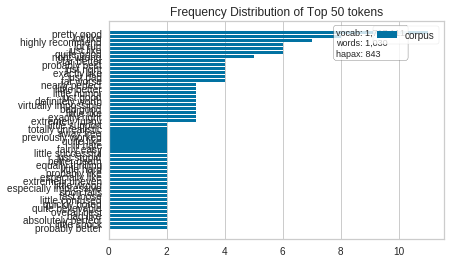

In [13]:
adv_bi_features = adv_bi_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=adv_bi_features)
visualizer.fit(adv_bi_bag_words)
visualizer.poof()

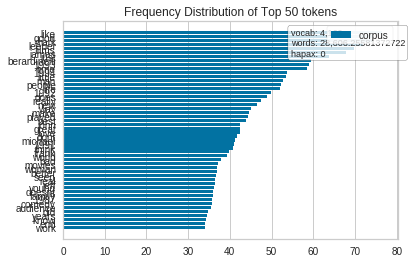

In [14]:
tfidf_features = tfidf_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=tfidf_features)
visualizer.fit(tfidf_bag_words)
visualizer.poof()